For Mariah, I am estimating the closeness of two human proteins, ENSP00000229239 and ENSP00000405573.

I will do so by comparing their geodesic distance to the average distance, estimated from a handful of random pairs.

In [1]:
"""Imports and arguments"""

import csv

import networkx as nx

import numpy as np
import scipy as sp
import numpy.linalg as lin
import numpy.random as rand
import matplotlib.pyplot as plt
import network_utilities as nu
import networkx.algorithms.community as nx_comm
import tensorflow as tf

# some basic settings for plotting figures
%matplotlib inline 
font = {'family' : 'serif',
        'weight' : 'light',
        'size'   : 20}

plt.rc('font', **font)

extra_outputs = False;

In [2]:
"""Loading data"""

# This is the variable that will store the protein names. 
ess_list = []; 

with open('essential_proteins.csv', newline='') as ess_file:
    reader = csv.reader(ess_file)
    ess_data = list(reader)

for i in range(len(ess_data)):
    ess_list.append(ess_data[i][1])
    
# Read in the string-db for Yeast
G0 = nx.read_weighted_edgelist("./homo_links.txt",comments="#",nodetype=str)

# For interest, plot the distribution of confidence scores
if (extra_outputs):
    plt.figure(figsize=(6,6));
    full_edges = G0.edges()
    these_weights = [G0[u][v]['weight'] for u,v in full_edges]

    plt.hist(these_weights, bins=40);
    plt.title("Confidence score distribution")
    plt.xlabel("Confidence score")
    plt.ylabel("# Edges")
    plt.show();
    
# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 700;
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])
        
# Take only the largest connected subgraph
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc);
print(G)

Graph with 16566 nodes and 251863 edges


First we look at the geodesic distance:

In [3]:
p1 = "ENSP00000229239"
p2 = "ENSP00000405573"

pp_distance = nx.shortest_path_length(G,p1,p2)
print(pp_distance)

1


Clearly this is unsatisfying. Let's examine the longer paths as well

In [31]:
p1i = list(G.nodes).index(p1)
p2i = list(G.nodes).index(p2)

A = nx.to_numpy_array(G, weight=None) # We have to get rid of the weights.
print(A[p1i,p2i])

# Then the powers of A are:

def An(n):
    return lin.matrix_power(A,n)

1.0


Take T random pairs of proteins, and calculate the number of paths of length l=1,2,...,L between them. Record the average
for each length, then compare to the same distribution for our two proteins of interest.

In [47]:
L = 4

N = len(list(G.nodes));

A_pows = [A] 
for l in range(0,L):
    print("Calculating power",l+1,"...")
    A_pows.append(np.matmul(A_pows[l],A))

print("Done!")
# precalculate the powers of A. This is sloooow

Calculating power 1 ...
Calculating power 2 ...
Calculating power 3 ...
Calculating power 4 ...


In [48]:
rand_Nls = list(np.zeros(L));
T = 10000
for t in range(T):
    pr1, pr2 = rand.choice(range(N), size=2, replace=False)
    for n in range(L):
        rand_Nls[n] += A_pows[n][pr1,pr2]
        #print("Done trial t =",t,"of",T,"at length l =",n,"of",L)

rand_Nls = [Nl/T for Nl in rand_Nls] # divide by the number of trials to get the mean
print(rand_Nls)

[0.0019, 0.1514, 16.1691, 1926.3682]


In [49]:
pp_Nls = list(np.zeros(L));
for n in range(L):
        pp_Nls[n] += A_pows[n][p1i,p2i]
print(pp_Nls)

[1.0, 31.0, 1551.0, 66343.0]


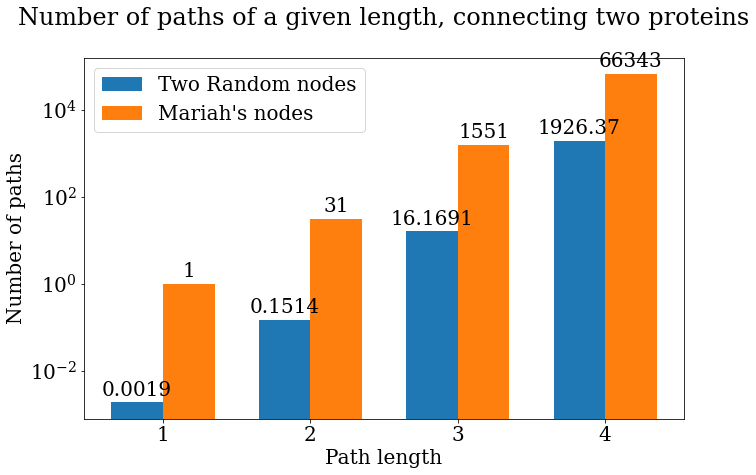

In [58]:
ls = range(1,L+1)

x = np.arange(len(ls))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, rand_Nls, width, label='Two Random nodes')
rects2 = ax.bar(x + width/2, pp_Nls, width, label="Mariah's nodes")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of paths')
ax.set_xlabel("Path length")
ax.set_title("Number of paths of a given length, connecting two proteins\n")
ax.set_xticks(x, ls)
ax.legend()
plt.yscale("log")

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [53]:
nodelist = list(G.nodes);

for t in range(10):
    pr1, pr2 = rand.choice(nodelist, size=2, replace=False)
    print(nx.shortest_path_length(G,pr1,pr2))

4
3
3
3
5
2
3
3
4
4
